In [61]:
import os
import shutil
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [62]:
base_data_dir = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'
train_dir = '/kaggle/working/Train'
test_dir = '/kaggle/working/Test'

In [63]:
split_ratio = 0.8

In [64]:
def organize_data(source_dir=base_data_dir, train_path=train_dir, test_path=test_dir, ratio=split_ratio):
    """Function to split dataset into training and testing sets."""
    
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    train_count, test_count = 0, 0

    for root, _, files in os.walk(source_dir):
        category = os.path.basename(root)

        if category == os.path.basename(source_dir):
            continue
        
        train_category_path = os.path.join(train_path, category)
        test_category_path = os.path.join(test_path, category)
        
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(test_category_path, exist_ok=True)
        
        image_files = glob.glob(os.path.join(root, '*.jpg'))
        print(f"Category '{category}' contains {len(image_files)} images.")
        np.random.shuffle(image_files)
        train_split = int(len(image_files) * ratio)
        
        train_files = image_files[:train_split]
        test_files = image_files[train_split:]
        
        for file in train_files:
            shutil.copy(file, os.path.join(train_category_path, os.path.basename(file)))
            train_count += 1
        
        for file in test_files:
            shutil.copy(file, os.path.join(test_category_path, os.path.basename(file)))
            test_count += 1

    print(f"Training set: {train_count} images.")
    print(f"Testing set: {test_count} images.")

In [65]:
organize_data()

Category 'Normal cases' contains 416 images.
Category 'Bengin cases' contains 120 images.
Category 'Malignant cases' contains 561 images.
Training set: 876 images.
Testing set: 221 images.


In [66]:
num_classes = 3
def create_model():
    """Build and compile a ResNet50-based model."""
    backbone = ResNet50(weights='imagenet', include_top=False)
    for layer in backbone.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(backbone.output)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax', name='fcnew')(x)
    model = Model(inputs=backbone.input, outputs=output)
    return model

In [67]:
model = create_model()
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [68]:
image_size = 224
batch_size = 64

train_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)

test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_loader = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_loader = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1097 images belonging to 3 classes.
Found 746 images belonging to 3 classes.


In [69]:
initial_epochs = 3
model.fit(
    train_loader,
    steps_per_epoch=train_loader.n // batch_size,
    validation_data=test_loader,
    validation_steps=test_loader.n // batch_size,
    epochs=initial_epochs,
    verbose=1
)

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5527 - loss: 1.4356 - val_accuracy: 0.8139 - val_loss: 0.5011
Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.8125 - loss: 0.5550

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.8125 - loss: 0.5550 - val_accuracy: 0.7381 - val_loss: 0.5067
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 720ms/step - accuracy: 0.8208 - loss: 0.4453 - val_accuracy: 0.8509 - val_loss: 0.3611


In [70]:
fine_tune_epochs = 30
freeze_layers = 140
for layer in model.layers[:freeze_layers]:
    layer.trainable = False
for layer in model.layers[freeze_layers:]:
    layer.trainable = True
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_loader,
    steps_per_epoch=train_loader.n // batch_size,
    validation_data=test_loader,
    validation_steps=test_loader.n // batch_size,
    epochs=fine_tune_epochs,
    verbose=1
)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8179 - loss: 0.4935 - val_accuracy: 0.8281 - val_loss: 0.4619
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9219 - loss: 0.3071 - val_accuracy: 0.8095 - val_loss: 0.3788
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 739ms/step - accuracy: 0.8739 - loss: 0.3269 - val_accuracy: 0.7997 - val_loss: 0.5365
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.2149 - val_accuracy: 0.7857 - val_loss: 0.5612
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 718ms/step - accuracy: 0.9273 - loss: 0.2272 - val_accuracy: 0.8224 - val_loss: 0.4404
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8438 - loss: 0.3500 - val_accuracy: 0.8095 - val_loss: 0.4194
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 778ms/step - accuracy: 0.9078 - loss: 0.2373 - val_accuracy: 0.8466 - val_loss: 0.3432
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.1720 - val_accuracy: 0.7857 -

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [72]:
true_labels = []
predicted_labels = []

In [73]:
test_loader.reset()  
for i in range(len(test_loader)):
    images, labels = test_loader[i]
    preds = model.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

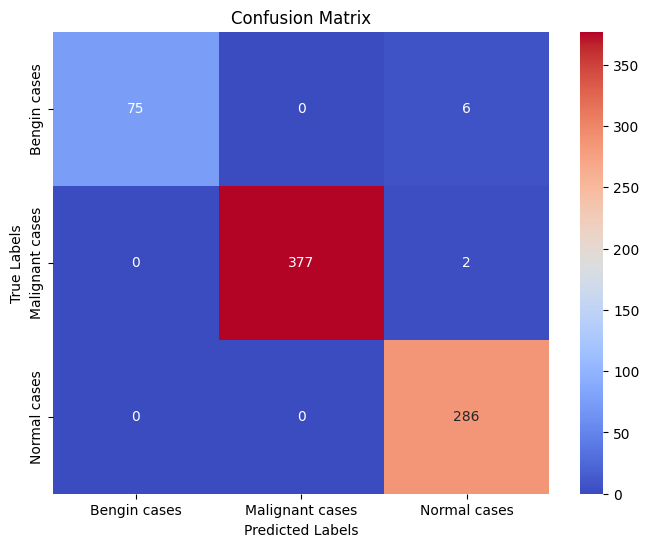

In [74]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_labels = list(test_loader.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [75]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.93      0.96        81
Malignant cases       1.00      0.99      1.00       379
   Normal cases       0.97      1.00      0.99       286

       accuracy                           0.99       746
      macro avg       0.99      0.97      0.98       746
   weighted avg       0.99      0.99      0.99       746

